In [1]:
# install
# pip install novosparc

In [2]:
# imports
%matplotlib inline
import novosparc

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr

import random
random.seed(0)

In [3]:
pl_genes = ['sna', 'ken', 'eve']

# Reconstructing the Drosophila embryo

This tutorial uses `novoSpaRc` to reconstruct single-cell gene expression of the Drosophila scRNA-seq dataset [Karaiskos et al., 2017, Science](https://science.sciencemag.org/content/358/6360/194). 

We differentiate between three modes of `novoSpaRc` reconstruction: 
1. Using only markers for reconstruction (using [Berkeley drosophila transcription network project ](http://bdtnp.lbl.gov/Fly-Net/bioimaging.jsp))
2. De novo, relying on cell-cell distances, and location-location distances similarity (no prior information) 
2. Integrating both assumptions

## Input cells and locations descriptions to construct Tissue object

### Reading gene expression data

In [4]:
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

number of cells: 1297
number of genes: 8924


### Preprocess data

In this example the data is saved after preprocessing. In the case of an unprocessed count matrix,  however, standard, or data-tailored preprocessing is recommended. Since novoSpaRc reads the dataset as a scanpy AnnData object, we use standardized preprocessing steps. For example:

In [5]:
# preprocess
# sc.pp.normalize_per_cell(dataset)
# sc.pp.log1p(dataset)

After preprocessing, it is worth observing the data size before proceeding. If cell numbers are large, we can subsample the number of cells:

In [6]:
# optional: subset cells
num_cells = 1000
sc.pp.subsample(dataset, n_obs=num_cells)

### (Optional) Generate low dimensional representation of the data
To reduce the noise, capture meaningful expression distances between cells and reduce runtimes, it is advisable to decrease the dimension of gene expression. This can be done, for example, by either subsetting the gene expression matrix for highly variable genes or using PCA representation. 

In [7]:
dge_rep = None # a representation of cells gene expression
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

# alternative 1: variable expressed genes representation
dge_rep = dataset.to_df()[var_genes]

# alternative 2: pca representation
sc.pp.pca(dataset)
# dge_rep = pd.DataFrame(dataset.obsm['X_pca'])

### Create a target space

1. When using expression of marker genes ($\alpha_{linear} > 0$), target space has to correspond to the atlas' locations.

**Otherwise, there are two alternatives:**

2. Prior shape without exact locations
3. No prior knowledge of target space

#### Alternative 1: using a reference atlas
If a reference atlas is used, then the target space has to consist of its locations. 

In [8]:
atlas_dir = 'novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

#### Alternative 2: using a prior shape without exact locations
It is possible that we know the general shape of the tissue but we are missing specific locations of the cells. In this case, the target space can be generated from a binary image:

In [9]:
tissue_path = 'novosparc/datasets/tissue_example.png'
locations_from_image = novosparc.gm.create_target_space_from_image(tissue_path)
locations_from_image = locations_from_image[np.random.choice(locations_from_image.shape[0], num_locations), :]

#### Alternative 3: no prior knowledge of the target space
novoSpaRc can create a target space by setting locations on certain basic shapes. Current supported shapes include filled circle, 2D torus projection, rectangular grid, sphere and torus. Grids can be populated with equidistant or randomly drawn points.

In [10]:
locations_circle = novosparc.gm.construct_circle(num_locations=num_locations)

Plots of the example target spaces:

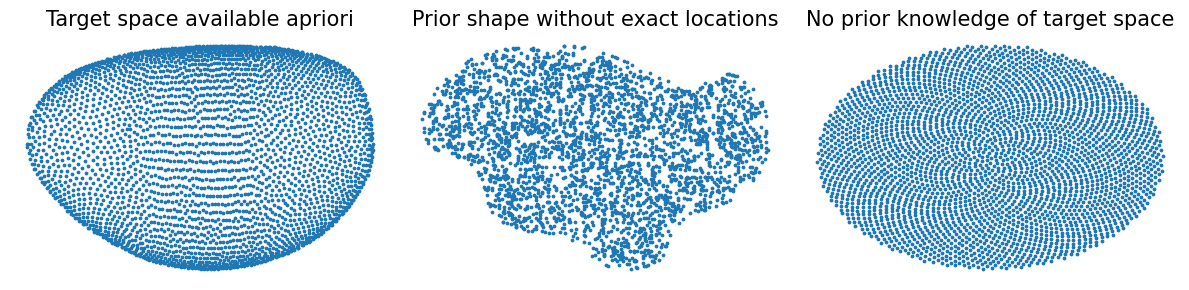

In [11]:
tit_size = 15
dpi = 100
fig, ax = plt.subplots(1,3, figsize=(12,3), dpi=dpi)

ax[0].scatter(locations_apriori[:, 0], locations_apriori[:, 1], s=3)
ax[1].scatter(locations_from_image[:, 0], locations_from_image[:, 1], s=3)
ax[2].scatter(locations_circle[:, 0], locations_circle[:, 1], s=3)

ax[0].set_title('Target space available apriori', size=tit_size)
ax[1].set_title('Prior shape without exact locations', size=tit_size)
ax[2].set_title('No prior knowledge of target space', size=tit_size)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

plt.tight_layout()
plt.show()

## Reconstruct the tissue de novo

### Construct Tissue object
So far, we constructed the input for the spatial reconstruction. Thus we next initialise a tissue object with the cell expression dataset and target space locations.


In [12]:
# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_from_image)

### Compute cost matrices
The OT framework interpolates between two assumptions, structural correspondence assumption and atlas assumption. 

With the de novo reconstruction we only need the structural correspondence assumption. For the structural correspondence (smooth) assumption we set the cells and locations the number of neighbors to use for constructing the k-Nearest Neighbors graph.

In [13]:
num_neighbors_s = num_neighbors_t = 5

# tissue.setup_reconstruction(num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# alternative: since we don't have the atlas assumption, we can also setup only the smooth costs.
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

Setting up for reconstruction ... done ( 3.94 seconds )


### Compute OT of cells to locations with a given alpha parameter

Now we can reconstruct our tissue. The `alpha_linear` parameter controls the contribution of the two branches in `novoSpaRc`: `alpha_linear=0` means that no prior information is available, while `alpha_linear=1` implies that the reconstruction will be only based on the reference marker genes provided. Here we aim for a de novo reconstruction.

In addition to setting alpha_linear, epsilon, the coefficient of the entropy can also be set. A low epsilon will result in a more definitive mapping and a higher epsilon with a more continuous one. Choosing a low epsilon often leads to numerical errors. Therefore, if this is the case, we attempt reconstruction with a greater epsilon.

In [14]:
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)

Reconstructing spatial information with 0 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


### Validate predicted expression over target space

Expression over the locations is computed and saved in tissue.sdge. This provides a genes x locations matrix describing the expression over the target space locations. 


/usr/local/opt/pyenv/versions/3.7.5/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


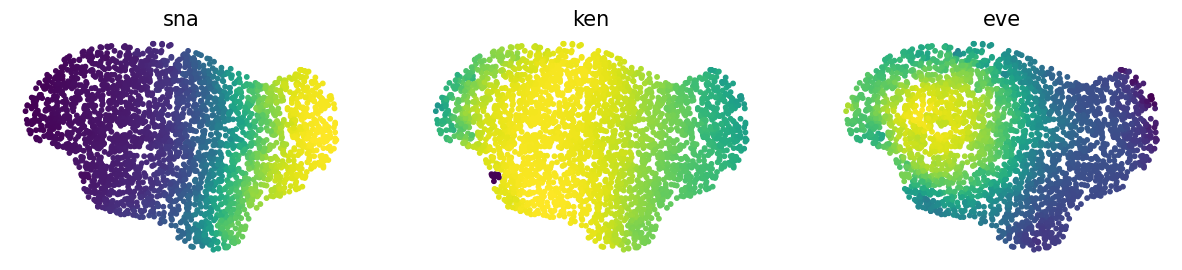

<Figure size 432x288 with 0 Axes>

In [15]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations_from_image

novosparc.pl.embedding(dataset_reconst, pl_genes)

## Reconstruct the tissue with marker genes

Available reference marker genes can assist to achieve a better reconstruction. The reference atlas we deploy here was previously analyzed to extract gene expression for the desired spatial resolution of the target space. All-in-all, the resulting atlas, e.g. atlas, rows correspond to positions of the target space locations, and columns to the atlas genes (therefore, if locations of the atlas were subset in the target space, then they need to be subset here as well).

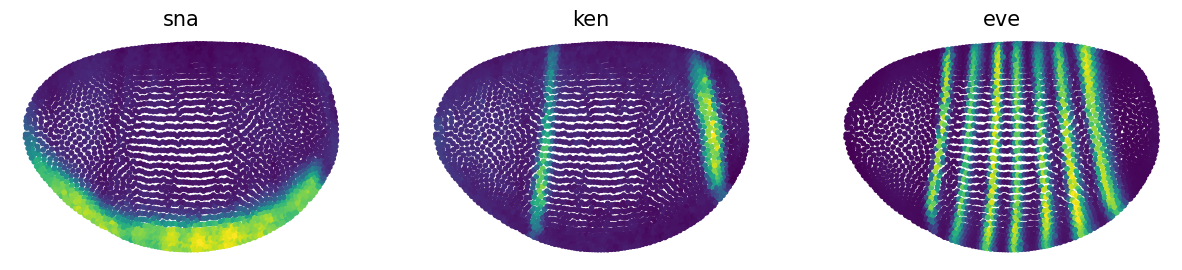

<Figure size 432x288 with 0 Axes>

In [16]:
# reading reference atlas
locations = locations_apriori
atlas_dir = 'novosparc/datasets/bdtnp/'
atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

novosparc.pl.embedding(atlas, pl_genes)

Note that expression can also be inferred over a configured target space from images or from previously binned spatial expression using interpolation tools for instance but we do not cover this here. 

#### Testing structural correspondence assumption in atlas
If an atlas is provided, then one can test to what extent the structural correspondence assumption holds. A proxy is to look at the loc-loc expression distances vs their physical distances, hoping to see an upward-going trend. 

Text(0.5, 1.0, '')

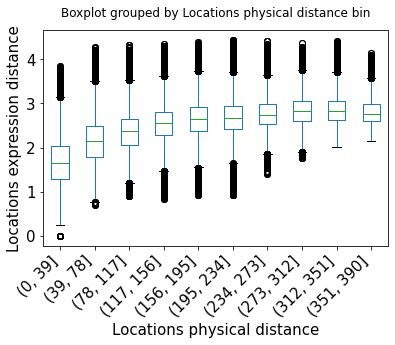

In [17]:
# Tip: visualizing loc-loc expression distances vs their physical distances
locs_exp_dist = squareform(pdist(atlas.X))
locs_phys_dist = squareform(pdist(locations))
exp_col = 'Locations expression distance'
phys_col = 'Locations physical distance'
phys_col_bin = 'Locations physical distance bin'

df = pd.DataFrame({exp_col: locs_exp_dist.flatten(), 
                  phys_col: locs_phys_dist.flatten()})

nbins = 10
lower, higher = int(df[phys_col].min()), int(np.ceil(df[phys_col].max()))
edges = range(lower, higher, int((higher - lower)/nbins)) # the number of edges is 8
lbs = ['(%d, %d]'%(edges[i], edges[i+1]) for i in range(len(edges)-1)]
df[phys_col_bin] = pd.cut(df[phys_col], bins=nbins, labels=lbs, include_lowest=True)

df.boxplot(column=[exp_col], by=[phys_col_bin], grid=False, fontsize=tit_size)
plt.xticks(rotation=45, ha='right')
plt.ylabel(exp_col, size=tit_size)
plt.xlabel(phys_col, size=tit_size)
plt.title('')

#### Testing spatial information in atlas
One can test how "spatially informative" are the marker genes. For single-cell data that originates from a separate tissue than the atlas, this is especially important to assess if the atlas will help reconstruction. We see here the genes in this atlas are indeed spatially informative. 

In [ ]:
# Tip: one can test how "spatially informative" are the marker genes. 
# one measure indicating how localized is the expression is Moran's I

mI, pvals = novosparc.an.get_moran_pvals(atlas.X, locations)
df = pd.DataFrame({'moransI': mI, 'pval': pvals}, index=atlas_genes)

gene_max_mI = df['moransI'].idxmax()
gene_min_mI = df['moransI'].idxmin()

title = ['%s, Morans`I=%.02f' % (gene_max_mI, df.loc[gene_max_mI]['moransI']), 
         '%s, Morans`I=%.02f' % (gene_min_mI, df.loc[gene_min_mI]['moransI'])]

novosparc.pl.embedding(atlas, [gene_max_mI, gene_min_mI], title=title)

print('Mean MoransI: %.02f' % df['moransI'].mean())

### Construct a Tissue object

In [ ]:
# construct Tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations)

### Compute cost matrices

Since we are using atlas (linear) assumption as well, we also compute the indices of the marker genes in the expression matrix:

In [ ]:
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)

# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

### Compute OT of cells to locations with a given alpha parameter

In [ ]:
# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

In [ ]:
# configure locations probability values
zlocations = (locations - locations.mean(0)) / (locations.std(0))
dist = cdist(zlocations, np.zeros((1,2)))
rdist = dist.max() - dist
rdist = (rdist / rdist.sum()).flatten()

atlas.obs['Alternative location marginals'] = rdist

novosparc.pl.embedding(atlas, ['Alternative location marginals'])
# tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon, p_locations=rdist)

### Validate predicted expression over target space

In [ ]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]
novosparc.pl.embedding(dataset_reconst, pl_genes, title=title)

In [ ]:
# # cross-validation and self-consistency analysis
# repeats = 3 #10
# num_markerss = [40]
# alpha_linears = np.arange(0.7, 0.9, 0.1) # np.arange(0.5, 1.0001, 0.1)


# df_corr_atlas, df_corr_repeats = novosparc.an.correlation_random_markers(tissue, with_atlas=True, with_repeats=True,
#                              alpha_linears=alpha_linears, epsilons=[epsilon], num_markerss=num_markerss, repeats=repeats)

# base = alt.Chart().mark_boxplot().encode(x=alt.X('alpha_linear:Q', axis=alt.Axis(values=alpha_linears), scale=alt.Scale(zero=False)),
#                                         y=alt.Y('Pearson correlation:Q', scale=alt.Scale(zero=False)),
#                                         color=alt.value('blue'), opacity=alt.value(0.5))

# pl_atlas = base.properties(data=df_corr_atlas, title='Correlation with atlas')
# pl_repeats = base.properties(data=df_corr_repeats, title='Correlation with repeats')

# alt.hconcat(pl_atlas, pl_repeats).configure_axis(grid=False, labelFontSize=15, titleFontSize=20)

### Validate localized mapping of individual cells
The mapping of cells to locations is available in tissue.gw. The dimensions of the matrix is cells x locations of the target space, and each entry is the “belong-ness” of a cell, to the spatial position. Cells can be spread across multiple locations as their expression can truthfully correlate with multiple locations within the tissue and the overall goal is to recover the spatial expression which is computed as a weighted sum of cells’ expression.

In [ ]:
# probability of individual cells belonging to each location
gw = tissue.gw
ngw = (gw.T / gw.sum(1)).T
cell_idx = [1, 12]
cell_prb_cols = ['cell %d' % i for i in cell_idx]
dataset_reconst.obs = pd.DataFrame(ngw.T[:, cell_idx], columns=cell_prb_cols)

title=['Cell %d, entropy=%.02f' % (i, novosparc.an.get_cell_entropy(ngw[i,:])) for i in cell_idx]
novosparc.pl.embedding(dataset_reconst, cell_prb_cols, title=title)

In [ ]:
# comparing distributions of entropy for transporting a cell to locations
ent_T, ent_T_unif, ent_T_rproj, ent_T_shuf = novosparc.pl.plot_transport_entropy_dist(tissue)

print(ks_2samp(ent_T, ent_T_rproj))
print(ks_2samp(ent_T, ent_T_shuf))

### Identifying spatially informative genes
In addition to inserting known marker genes, we can also look for spatially informative genes from the reconstruction results:

In [ ]:
# Looking for spatially informative genes according to reconstruction in highly variable genes

cyc_genes = [g for g in gene_names if g.startswith('Cyc')]
atlas_genes = list(atlas.var_names)
mI_genes = cyc_genes + atlas_genes

tissue.calculate_spatially_informative_genes(mI_genes)
genes_with_scores = tissue.spatially_informative_genes

genes_with_scores.index = genes_with_scores['genes']

gene_groups = {'Atlas': atlas_genes, 'Cell-cycle': cyc_genes}
novosparc.pl.plot_morans_dists(genes_with_scores, gene_groups)

gene_max_mI = genes_with_scores['genes'].iloc[0]
gene_min_mI = genes_with_scores['genes'].iloc[-1]

title = ['%s, Morans`I=%.02f' % (gene_max_mI, genes_with_scores.loc[gene_max_mI]['mI']), 
         '%s, Morans`I=%.02f' % (gene_min_mI, genes_with_scores.loc[gene_min_mI]['mI'])]

novosparc.pl.embedding(dataset_reconst, [gene_max_mI, gene_min_mI], title=title)

print('Mean Morans I for cell-cycle genes: %.02f' % genes_with_scores.loc[cyc_genes]['mI'].mean())
print('Mean Morans I for atlas genes: %.02f' % genes_with_scores.loc[atlas_genes]['mI'].mean())

### Extract archetypes

In [ ]:
# plot spatial expression archtypes
num_clusters = 10
atlas_indices = pd.DataFrame(np.arange(num_genes), index=gene_names)[0].loc[atlas_genes].values
archetypes, clusters, gene_corrs = novosparc.rc.find_spatial_archetypes(num_clusters, sdge[atlas_indices,:])

arch_cols = ['archetype %d'% i for i in np.arange(num_clusters)]
dataset_reconst.obs = pd.DataFrame(index=dataset_reconst.obs.index)
df = pd.DataFrame(archetypes.T, columns=arch_cols)
dataset_reconst.obs = pd.concat((dataset_reconst.obs, df), 1)

novosparc.pl.embedding(dataset_reconst, arch_cols)